# Fitting with Varying Fracface Pressure

More advanced use of `bluebonnet.flow` in a project where pressure variation at the frac-face or bottom-hole is approximately known.

First, import the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate

from bluebonnet.flow import FlowProperties, SinglePhaseReservoir
from bluebonnet.fluids import build_pvt_gas
from bluebonnet.forecast.forecast_pressure import (
    fit_production_pressure,
    plot_production_comparison,
)

mf = 0.09720937870967307
CPU times: user 718 ms, sys: 1.47 ms, total: 719 ms
Wall time: 719 ms
0.3642368902150243
pseudopressure_fracface=array(0.09720938) 0.0008833316702989393 Deviation is  -1%


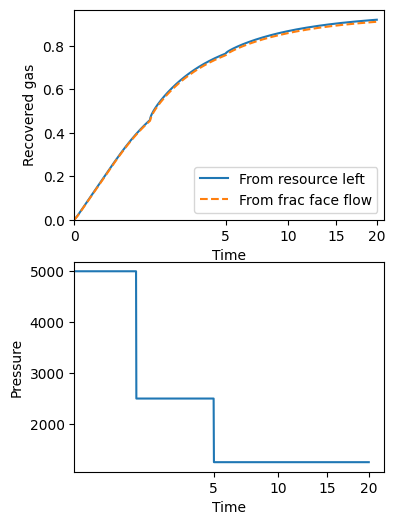

In [2]:
pressure_initial = 12_000.0
pressure_fracface = 5_000.0

n_times = 1_000
t_end = 20
time = np.linspace(0, np.sqrt(t_end), n_times) ** 2
pressure_v_time = np.full(n_times, pressure_fracface)
pressure_v_time[n_times // 4 : n_times // 2] /= 2.0
pressure_v_time[n_times // 2 :] /= 4.0

pvt_gas = pd.read_csv(
    "https://raw.githubusercontent.com/frank1010111/bluebonnet/main/tests/data/pvt_gas.csv"
).rename(
    columns={
        "P": "pressure",
        "Z-Factor": "z-factor",
        "Cg": "compressibility",
        "Viscosity": "viscosity",
    }
)
flow_properties = FlowProperties(pvt_gas, pressure_initial)
pseudopressure_fracface = flow_properties.m_scaled_func(pressure_fracface)
pseudopressure_initial = flow_properties.m_scaled_func(pressure_initial)

print("mf =", flow_properties.m_scaled_func(pressure_fracface))

res = SinglePhaseReservoir(100, pressure_fracface, pressure_initial, flow_properties)

%time res.simulate(time, pressure_v_time)

recovery = res.recovery_factor()


def resource_left(pseudopressure, pvt):
    density = interpolate.interp1d(pvt.pvt_props["m-scaled"], pvt.pvt_props["Density"])
    print(max(pvt.pvt_props["m-scaled"]))
    p = np.minimum(pseudopressure, max(pvt.pvt_props["m-scaled"]))
    return (density(p)).sum(axis=1) / len(pseudopressure[0])


density_interp = interpolate.interp1d(
    flow_properties.pvt_props["m-scaled"], flow_properties.pvt_props["Density"]
)
remaining_gas = (resource_left(res.pseudopressure, flow_properties)) / (
    density_interp(pseudopressure_initial)
)
print(
    f"{pseudopressure_fracface=}",
    res.pseudopressure[-1][0],
    f"Deviation is {(recovery[-1] - 1 + remaining_gas[-1]) / recovery[-1] * 100:3.2g}%",
)
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(4, 6)
ax1.plot(time, 1 - remaining_gas, label="From resource left")
ax1.plot(time, recovery, "--", label="From frac face flow")
ax1.legend()
ax1.set(
    xlabel="Time",
    ylabel="Recovered gas",
    ylim=(0, None),
    xscale="squareroot",
    xlim=(0, None),
)

ax2.plot(time, pressure_v_time, label="Pressure")
ax2.set(xlabel="Time", xscale="squareroot", ylabel="Pressure");

## Build PVT data

There are two ways to create the necessary pressure-volume-temperature data. 
1. Use the well data and an appropriate equation of state
2. Pull data from a pre-made csv file. 

We will show both with the next code cell.

In [3]:
# #########################
# Haynesville shale gas play
# Using the well data and bluebonnet.fluids
# #########################
field_values = {
    "N2": 0.0,
    "H2S": 0.0,
    "CO2": 0.0002,
    "Gas Specific Gravity": 0.58,
    "Reservoir Temperature (deg F)": 285.21375,
}
gas_dryness = "wet gas"
pvt_gas = build_pvt_gas(field_values, gas_dryness)


# #########################
# Or, you could using pre-gathered pvt data
# #########################
# pvt_gas = pd.read_csv(
#    "https://raw.githubusercontent.com/frank1010111/bluebonnet/main/tests/data/pvt_gas_HAYNESVILLE%20SHALE_20.csv",
#    index_col=0
# )

print(pvt_gas.head())

   temperature  pressure   Density  z-factor  compressibility  viscosity  \
0    285.21375      10.0  0.021024  0.999592         0.100043   0.014638   
1    285.21375      20.0  0.042065  0.999181         0.050043   0.014638   
2    285.21375      30.0  0.063123  0.998775         0.033376   0.014639   
3    285.21375      40.0  0.084198  0.998370         0.025043   0.014639   
4    285.21375      50.0  0.105290  0.997967         0.020042   0.014640   

   pseudopressure  
0        0.000000  
1    20508.736605  
2    54702.013998  
3   102589.697359  
4   164181.289746  


## Fit wells

In [4]:
well_number = "20"
prod_file = f"https://raw.githubusercontent.com/frank1010111/bluebonnet/main/data/dataset_1_well_{well_number}.csv"
# This file contains pressure and production data.
# Rows 1 and 2 have information about units, so skip
prod = pd.read_csv(prod_file, skiprows=[1, 2]).rename(
    columns={
        "Time (Days)": "Days",
        "Gas Volume (MMscf)": "Gas",
        "Calculated Sandface Pressure  (psi(a))": "Pressure",
    }
)[["Days", "Gas", "Pressure"]]
# This file contains an estimate of initial pressure. That's all I need it for here.
well_file = f"https://media.githubusercontent.com/media/frank1010111/bluebonnet/main/data/WellData_{well_number}.csv"
pressure_initial = float(
    pd.read_csv(well_file)
    .set_index("Field")
    .loc["Initial Pressure Estimate (psi)"]
    .iloc[0]
)

result = fit_production_pressure(
    prod,
    pvt_gas,
    pressure_initial,
    n_iter=40,
    pressure_imax=12000,
    filter_window_size=30,
    inplace_max=100000,
)
result

## Plot the result

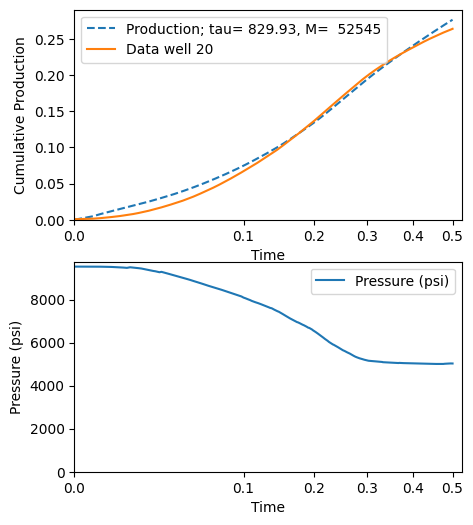

In [5]:
fig, (ax1, ax2) = plot_production_comparison(
    prod,
    pvt_gas,
    result.params,
    filter_window_size=30,
    well_name=f"Data well {well_number}",
)